## Семинар 6 "Segmentation"

ФИО: Намит Максим Михайлович

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imagecodecs

     |████████████████████████████████| 24.7MB 128kB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io
import imagecodecs

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [ ]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('drive/MyDrive/data/test/images/')
t.save(test, TEST_PATH)
train_data = process('drive/MyDrive/data/train/images', "drive/MyDrive/data/train/1st_manual/")

In [ ]:
import torch

In [ ]:
from random import uniform, choice
angle =  np.random.choice([10, 20, 30], size=1)
print(angle)

[30]


In [ ]:
import PIL

class GaussianNoise(object):
  def __init__(self, mean=0., std=1.):
    self.std = std
    self.mean = mean

  def __call__(self, tensor):
    return tensor + torch.randn(tensor.size()) * self.std + self.mean

class MakeRotation(object):
  def __init__(self, alpha):
    self.alpha = alpha
  def __call__(self, x):
    return tsf.functional.rotate(x, self.alpha)

class Dataset():
    def __init__(self,data):
        self.datas = data

    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        #rot = tsf.RandomRotation(90)
        #angle = np.random.choice(np.array([10, 45, 90, 180, -180, -90, -45, -10], dtype=float), size=1)[0]
        #print(angle)
        angle = np.random.uniform(-10,10, size = 1)
        s_trans = tsf.Compose([
          tsf.ToPILImage(),
          tsf.ToTensor(),
          MakeRotation(angle),
          GaussianNoise(0., 0.005),
          tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
        ])
        t_trans = tsf.Compose([
          tsf.ToPILImage(),
          MakeRotation(angle),
          tsf.ToTensor(),
        ])
        return s_trans(img), t_trans(mask)

    def __len__(self):
        return len(self.datas)


dataset = Dataset(train_data)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

10.0


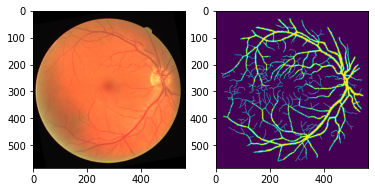

In [ ]:
img,mask = dataset[3]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [ ]:
# sub-parts of the U-Net model

from torch import nn
import torch.nn.functional as F

In [ ]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
            )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv_1 = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.sigmoid(x)
        return x

In [ ]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.sigmoid(x)
        return x

In [ ]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [ ]:
import torch

In [ ]:
device_ = torch.device('cuda')
model = UNet(3, 1).to(device_)

In [ ]:

s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
])

class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset, batch_size=1)

In [ ]:
from IPython.display import clear_output
import sys

In [ ]:
def train(network, train_loader, epochs, 
          learning_rate):
    loss = soft_dice_loss
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    train_accuracy_epochs = []
    network = network.to('cuda')
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.to('cuda')
                y = y.to('cuda')
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.cpu().item())
                loss_batch.backward()
                optimizer.step()
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            sys.stdout.write('\rEpoch {0}... (Train) LOSS: {1:.3f}'.format(
                            epoch, train_loss_epochs[-1]))
            plot = True
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           train_accuracy_epochs

Epoch 74... (Train) LOSS: 0.183

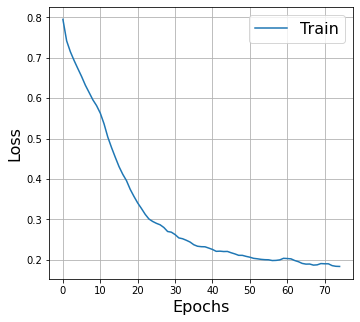

([0.7951405644416809,
  0.7418729662895203,
  0.7147710442543029,
  0.6930921792984008,
  0.6730925679206848,
  0.6535674452781677,
  0.632171881198883,
  0.6142022490501404,
  0.5960086107254028,
  0.5815431714057923,
  0.5628367304801941,
  0.5364534974098205,
  0.5037767648696899,
  0.4777558445930481,
  0.45375176668167116,
  0.4306587815284729,
  0.41161863803863524,
  0.39580042362213136,
  0.37421969175338743,
  0.3566809296607971,
  0.340503466129303,
  0.3268920421600342,
  0.3124503493309021,
  0.30085320472717286,
  0.2947377681732178,
  0.29006662368774416,
  0.2864344835281372,
  0.2797379016876221,
  0.26986507177352903,
  0.26812162399291994,
  0.2622308611869812,
  0.25395371913909914,
  0.251929247379303,
  0.24810166358947755,
  0.24373711347579957,
  0.2370791792869568,
  0.23332910537719725,
  0.23222867250442505,
  0.23196227550506593,
  0.22878252267837523,
  0.22540000677108765,
  0.22070425748825073,
  0.22114095687866211,
  0.22021965980529784,
  0.220456075668

In [ ]:
train(model, dataloader, 75, 0.001)


In [ ]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    #tsf.Resize((400,400)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
])
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
test_dataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [ ]:
len(test_dataloader)

20

In [ ]:
#os.makedirs("drive/MyDrive/data/test/result")
!zip -r result.zip result

	zip warning: name not matched: result

zip error: Nothing to do! (try: zip -r result.zip . -i result)


In [ ]:
import skimage.transform

In [ ]:
import imageio


In [ ]:
model = model.eval()
for ex_id, data in enumerate(test_dataloader):
    data = t.autograd.Variable(data, volatile=True).cuda()
    o = model(data)
    print('!')
    source_image = io.imread("drive/MyDrive/data/test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("drive/MyDrive/data/test/result/%s.png" % (ex_id + 1), tm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


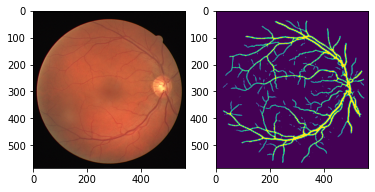

In [ ]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)

Отчет: 
Эксперементировал с данными - помогло удаление resize а также небольшой случайный шум со случайными вращениями.